# **CS224W - Colab 3**

In Colab 2 we constructed GNN models by using PyTorch Geometric built in GCN layer, the `GCNConv`. In this Colab we will implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) and **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) layers directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.

We will then use [DeepSNAP](https://snap.stanford.edu/deepsnap/), a Python library assisting efficient deep learning on graphs, to split the graphs in different settings and apply dataset transformations.

At last, using DeepSNAP transductive link prediction split functionality, we will construct a simple GNN model on the edge property predition (link prediction) task.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

Have fun on Colab 3 :)

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [ ]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
# !pip install -q torch-geometric
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [1]:
!nvidia-smi

Sat Jul 23 03:52:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.12.0+cu113


In [3]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
# !pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 30.7 MB/s 
     |████████████████████████████████| 3.5 MB 28.1 MB/s 
     |████████████████████████████████| 407 kB 11.3 MB/s 


In [4]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

# 1 GNN Layers

## Implementing Layer Modules

In colab 2, we implemented a network using GCN in node and graph classification tasks. However, the GCN module we used in colab 2 is from the official library. For this problem, we will provide you with a general Graph Neural Network Stack, where you'll be able to plugin your own modules of GraphSAGE and GATs. We will use our implementations to complete node classification on CORA, which is a standard citation network benchmark dataset. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node has a class label. The node features are elements of a bag-or-words representation of a document. For the Cora dataset, there are 2708 nodes, 5429 edges, 7 prediction classes for nodes, and 1433 features per node. 

- GraphSAGE와 GAT를 다룰 것이다.
- CORA Dataset을 다루는데, CORA에서 Node를 분류하는 작업을 할 것이다.
- CORA : Standard citation network benchmark dataset
- Node : Documents
- Edge : undirected citations
- 각 Node : Class Label을 가지고 있다.
- Node Feature : Document의 bag-or-words Representation of a document
- Cora : 2708개 Node, 5429개 Edge, Node에 대하여 7개의 예측 클래스, Node마다 1433개 Features

## GNN Stack Module

Below is the implementation for a general GNN Module that could plugin any layers, including **GraphSage**, **GAT**, etc. This module is provided for you, and you own **GraphSage** and **GAT** layers will function as components in the GNNStack Module.

In [ ]:
# import torch
# import torch_scatter
# import torch.nn as nn
# import torch.nn.functional as F

# import torch_geometric.nn as pyg_nn
# import torch_geometric.utils as pyg_utils

# from torch import Tensor
# from typing import Union, Tuple, Optional
# from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
#                                     OptTensor)

# from torch.nn import Parameter, Linear
# from torch_sparse import SparseTensor, set_diag
# from torch_geometric.nn.conv import MessagePassing
# from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

# class GNNStack(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
#         super(GNNStack, self).__init__()
#         conv_model = self.build_conv_model(args.model_type)
#         self.convs = nn.ModuleList()
#         self.convs.append(conv_model(input_dim, hidden_dim))
#         assert (args.num_layers >= 1), 'Number of layers is not >=1'
#         for l in range(args.num_layers-1):
#             self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

#         # post-message-passing
#         self.post_mp = nn.Sequential(
#             nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
#             nn.Linear(hidden_dim, output_dim))

#         self.dropout = args.dropout
#         self.num_layers = args.num_layers

#         self.emb = emb

#     def build_conv_model(self, model_type):
#         if model_type == 'GraphSage':
#             return GraphSage
#         elif model_type == 'GAT':
#             # When applying GAT with num heads > 1, one needs to modify the 
#             # input and output dimension of the conv layers (self.convs),
#             # to ensure that the input dim of the next layer is num heads
#             # multiplied by the output dim of the previous layer.
#             # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
#             # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
#             # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
#             return GAT

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
          
#         for i in range(self.num_layers):
#             x = self.convs[i](x, edge_index)
#             x = F.relu(x)
#             x = F.dropout(x, p=self.dropout)

#         x = self.post_mp(x)

#         if self.emb == True:
#             return x

#         return F.log_softmax(x, dim=1)

#     def loss(self, pred, label):
# return F.nll_loss(pred, label)

In [ ]:
# GNN Stack Module

import torch

# torch에서 scatter 합치는 것을 의미한다.
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

# pyg_nn, pyg_utils
import torch_geometric as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

In [ ]:
# class GNNStack(torch.nn.Module):
#   def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
#     super(GNNStack, self).__init__()
#     conv_model = self.build_conv_model(args.model_type)
#     self.convs = nn.ModuleList()
#     self.convs.append(conv_model(input_dim, hidden_dim))
#     assert (args.num_layers >= 1), 'Number of layers is not >= 1'
    
#     for i in range(args.num_layers-1):
#       self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))
    
#     # Post Message Passing
#     self.post_mp = nn.Sequential(
#         nn.Linear(args.heads * hidden_dim, hidden_dim),
#         nn.Dropout(args.dropout),
#         nn.Linear(hidden_dim, output_dim)
#     )

#     self.dropout = args.dropout
#     self.num_layers = args.num_layers
#     self.emb = emb

#   def build_conv_model(self, model_type):
#     if model_type == 'GraphSage':
#       return GraphSage
#     elif model_type == 'GAT':
#       # When applying GAT with num heads > 1, you need to modify the input and output dimension of the conv layers (self.convs)
#       # to ensure that the input dim of the next layer is num heads multiplied by the output dim of the previous layer.
      
#       # HINT : In case you want to play with multiheads, you need to change the for-loop that builds up self.convs to be self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim))
#       # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.

#       return GAT
    
#   def forward(self, data):
#     x, edge_index, batch = data.x, data.edge_index, data.batch

#     for i in range(self.num_layers):
#       x = self.convs[i](x, edge_index)
#       x = F.relu(x)
#       x = F.dropout(x, p=self.dropout, training=self.training)

#     x = self.post_mp(x)

#     if self.emb == True:
#       return x
    
#     return F.log_softmax(x, dim=1)

#   def loss(self, pred, label):
#     return F.nll_loss(pred, label)

In [ ]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, you need to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop that builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

### 7월 23일 (토) 다시 복습.

In [5]:
import torch

# torch에서 scatter 합치는 것을 의미.
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

# pyg_nn, pyg_utils
import torch_geometric as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

# torch geometric -> nn.conv, utils
from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

In [29]:
class GNNStack(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
    super(GNNStack, self).__init__()
    conv_model = self.build_conv_model(args.model_type)
    self.convs = nn.ModuleList()
    self.convs.append(conv_model(input_dim, hidden_dim))
    assert (args.num_layers >= 1), 'Number of layers is not >= 1'
    
    for I in range(args.num_layers-1):
      self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

    # post-message-passing
    self.post_mp = nn.Sequential(
        nn.Linear(args.heads * hidden_dim, hidden_dim),
        nn.Dropout(args.dropout),
        nn.Linear(hidden_dim, output_dim)
    )

    self.dropout = args.dropout
    self.num_layers = args.num_layers
    self.emb = emb

  def build_conv_model(self, model_type):
    if model_type=='GraphSage':
      return GraphSage
    
    elif model_type=='GAT':
      return GAT

  def forward(self, data):
    x = data.x
    edge_index = data.edge_index
    batch = data.batch

    for i in range(self.num_layers):
      x = self.convs[i](x, edge_index)
      x = F.relu(x)
      x = F.dropout(x, 
                    p = self.dropout, 
                    training = self.training)
    
    x = self.post_mp(x)

    if self.emb == True:
      return x
    return F.log_softmax(x, dim=1)

  def loss(self, pred, label):
    return F.nll_loss(pred, label)

## GraphSage Implementation

Now let's start working on our own implementation of layers! This part is to get you familiar with how to implement Pytorch layer based on Message Passing. You will be implementing the **forward**, **message** and **aggregate** functions.

Generally, the **forward** function is where the actual message passing is conducted. All logic in each iteration happens in **forward**, where we'll call **propagate** function to propagate information from neighbor nodes to central nodes.  So the general paradigm will be pre-processing -> propagate -> post-processing.

Recall the process of message passing we introduced in homework 1. **propagate** further calls **message** which transforms information of neighbor nodes into messages, **aggregate** which aggregates all messages from neighbor nodes into one, and **update** which further generates the embedding for nodes in the next iteration.

Our implementation is slightly variant from this, where we'll not explicitly implement **update**, but put the logic for updating nodes in **forward** function. To be more specific, after information is propagated, we can further conduct some operations on the output of **propagate**. The output of **forward** is exactly the embeddings after the current iteration.

In addition, tensors passed to **propagate()** can be mapped to the respective nodes $i$ and $j$ by appending _i or _j to the variable name, .e.g. x_i and x_j. Note that we generally refer to $i$ as the central nodes that aggregates information, and refer to $j$ as the neighboring nodes, since this is the most common notation.

Please find more details in the comments. One thing to note is that we're adding **skip connections** to our GraphSage. Formally, the update rule for our model is described as below:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

For simplicity, we use mean aggregations where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Additionally, $\ell$-2 normalization is applied after each iteration.

In order to complete the work correctly, we have to understand how the different functions interact with each other. In **propagate** we can pass in any parameters we want. For example, we pass in $x$ as an parameter:

... = propagate(..., $x$=($x_{central}$, $x_{neighbor}$), ...)

Here $x_{central}$ and $x_{neighbor}$ represent the features from **central** nodes and from **neighbor** nodes. If we're using the same representations from central and neighbor, then $x_{central}$ and $x_{neighbor}$ could be identical.

Suppose $x_{central}$ and $x_{neighbor}$ are both of shape N * d, where N is number of nodes, and d is dimension of features.

Then in message function, we can take parameters called $x\_i$ and $x\_j$. Usually $x\_i$ represents "central nodes", and $x\_j$ represents "neighbor nodes". Pay attention to the shape here: $x\_i$ and $x\_j$ are both of shape E * d (**not N!**). $x\_i$ is obtained by concatenating the embeddings of central nodes of all edges through lookups from $x_{central}$ we passed in propagate. Similarly, $x\_j$ is obtained by concatenating the embeddings of neighbor nodes of all edges through lookups from $x_{neighbor}$ we passed in propagate.

Let's look at an example. Suppose we have 4 nodes, so $x_{central}$ and $x_{neighbor}$ are of shape 4 * d. We have two edges (1, 2) and (3, 0). Thus, $x\_i$ is obtained by $[x_{central}[1]^T; x_{central}[3]^T]^T$, and $x\_j$ is obtained by $[x_{neighbor}[2]^T; x_{neighbor}[0]^T]^T$

<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>

In [ ]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.lin_l = torch.nn.Linear(self.in_channels, self.out_channels)
        self.lin_r = torch.nn.Linear(self.in_channels, self.out_channels)

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. First call propagate function to conduct the message passing.
        #    1.1 See there for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We use the same representations for central (x_central) and 
        #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
        #        to propagate.
        # 2. Update our node embedding with skip connection.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        # So the general paradigm will be pre-processing -> propagate -> post-processing.

        # 1. First call propagate function to conduct the message passing.
        #    1.1 See there for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We use the same representations for central (x_central) and 
        #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
        #        to propagate.
        prop = self.propagate(edge_index, x=(x, x), size=size)

        # 2. Update our node embedding with skip connection.
        out = self.lin_l(x) + self.lin_r(prop)

        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        if self.normalize:
          out = F.normalize(out, p=2)

        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = x_j

        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        # scatter : 흩뿌리다. 뿌리다. 산재해있다.
        out = torch_scatter.scatter(inputs, index, node_dim, dim_size=dim_size, reduce='mean')

        ############################################################################

        return out


In [19]:
# pre-processing -> propagate -> post-processing

class GraphSage(MessagePassing):
  def __init__(self, in_channels, out_channels, normalize=True, bias=False, **kwargs):
    super(GraphSage, self).__init__(**kwargs)
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.normalize = normalize
    
    # Define the layers needed for the message and update functions below.

    # self.lin_l : the linear transformation that you apply to embedding for central node.
    # self.lin_r : the linear transformation that you apply to aggregated message from neighbors

    self.lin_l = torch.nn.Linear(self.in_channels, self.out_channels)
    self.lin_r = torch.nn.Linear(self.in_channels, self.out_channels)

    self.reset_parameters()

  def reset_parameters(self):
    self.lin_l.reset_parameters()
    self.lin_r.reset_parameters()

  def forward(self, x, edge_index, size=None):
    # 1. First call propagate function to conduct the message passing.
    #    1.1 See there for more information: 
    #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
    #    1.2 We use the same representations for central (x_central) and 
    #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
    #        to propagate.

    prop = self.propagate(edge_index, x = (x, x), size = size)

    # 2. Update our node embedding with skip connection.
    
    out = self.lin_l(x) + self.lin_r(prop)

    # 3. If normalize is set, do L-2 normalization (defined in 
    #    torch.nn.functional)
    
    if self.normalize:
      out = F.normalize(out, p=2)
    
    return out

  def message(self, x_j):
    # Implement your message function here.
    out = x_j
    return out

  def aggregate(self, inputs, index, dim_size=None):
    # The axis along which to index number of nodes.
    node_dim = self.node_dim

    # Implement your aggregate function here.
    # See here as how to use torch_scatter.scatter: 
    # scatter : 흩뿌리다, 뿌리다, 산재해있다.
    out = torch_scatter.scatter(inputs, 
                                index, 
                                node_dim, 
                                dim_size=dim_size, 
                                reduce='mean')
    
    return out


## GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, we will see how attention mechanisms can be used to perform node classification of graph-structured data through the usage of Graph Attention Networks (GATs).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function . Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe this transformation of the input features into higher-level features performed by each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. Next, we perform self-attention on the nodes. We use a shared attentional mechanism:
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

This mechanism computes the attention coefficients that capture the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. To utilize graph structure in the attention mechanisms, we can use masked attention. In masked attention, we only compute $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vector $\overrightarrow{a} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]$ and $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.

In [ ]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using 
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)

        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here! 
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
      # Parameter이므로 Xavier Uniform을 통해 파라미터들을 Reset한다.
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)

        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r

        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.reshape(-1, H*C)

        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)

        if ptr:
          att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
          att_weight = torch_geometric.utils.softmax(alpha_i + alpha_j, index)
        
        att_weight = F.dropout(att_weight, p=self.dropout)
        out = att_weight * x_j

        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='sum')

        ############################################################################
    
        return out

In [20]:
class GAT(MessagePassing):
  def __init__(self, in_channels, out_channels, heads=2, negative_slope=0.2, dropout=0., **kwargs):
    super(GAT, self).__init__(node_dim=0, **kwargs)
    
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.heads = heads
    self.negative_slope = negative_slope
    self.dropout = dropout

    # Define the layers needed for the message functions below.
    # self.lin_l is the linear transformation that you apply to embeddings BEFORE Message Passing
    # Pay attention to dimensions of the linear layers, since we're using multi-head attention.

    self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)
    self.lin_r = self.lin_l

    # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
    # You have to deal with multi-head scenarios.
    # Use nn.Parameter instead of nn.Linear

    self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
    self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))

    self.reset_parameters()

  def reset_parameters(self):
    nn.init.xavier_uniform_(self.lin_l.weight)
    nn.init.xavier_uniform_(self.lin_r.weight)
    nn.init.xavier_uniform_(self.att_l)
    nn.init.xavier_uniform_(self.att_r)

  def forward(self, x, edge_index, size=None):
    H = self.heads
    C = self.out_channels

    # Implement message passing, as well as any pre- and post-processing (our update rule).

    # 1. First apply linear transformation to node embeddings, and split that 
    #    into multiple heads. We use the same representations for source and
    #    target nodes, but apply different linear weights (W_l and W_r)
    # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
    # 3. Call propagate function to conduct the message passing. 
    #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
    #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
    # 4. Transform the output back to the shape of N * d. 

    x_l = self.lin_l(x).reshape(-1, H, C)
    x_r = self.lin_r(x).reshape(-1, H, C)

    alpha_l = self.att_l * x_l
    alpha_r = self.att_r * x_r

    out = self.propagate(edge_index,
                         x = (x_l, x_r),
                         alpha = (alpha_l, alpha_r),
                         size = size)
    
    out = out.reshape(-1, H*C)

    return out

  def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
    # Implement your message function. Putting the attention in message 
    # instead of in update is a little tricky.
    # 1. Calculate the final attention weights using alpha_i and alpha_j,
    #    and apply leaky Relu.
    # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
    #    torch_geometric.utils.softmax instead of the one in Pytorch.
    # 3. Apply dropout to attention weights (alpha).
    # 4. Multiply embeddings and attention weights. As a sanity check, the output
    #    should be of shape E * H * d.
    # 5. ptr (LongTensor, optional): If given, computes the softmax based on
    #    sorted inputs in CSR representation. You can simply pass it to softmax.

    alpha = F.leaky_relu(alpha_i + alpha_j,
                         negative_slope = negative_slope)

    if ptr:
      att_weight = F.softmax(alpha_i + alpha_j, ptr)

    else:
      att_weight = torch_geometric.softmax(alpha_i + alpha_j, index)

    att_weight = F.dropout(att_weight, p = self.dropout)
    out = att_weight * x_j
    return out

  def aggregate(self, inputs, index, dim_size=None):
    # Implement your aggregate function here.
    # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
    # Pay attention to "reduce" parameter is different from that in GraphSage.
    # Our implementation is ~1 lines, but don't worry if you deviate from this.

    out = torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='sum')

    return out

## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.

In [21]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [22]:
import torch.optim as optim

def build_optimizer(args, params):
  weight_decay = args.weight_decay
  filter_fn = filter(lambda p: p.requires_grad, params)

  if args.opt == 'adam':
    optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
  
  elif args.opt == 'sgd':
    optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay = weight_decay)
  
  elif args.opt == 'rmsprop':
    optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)

  elif args.opt == 'adagrad':
    optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)

  if args.opt_scheduler == 'none':
    return None, optimizer

  elif args.opt_scheduler == 'step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)

  elif args.opt_scheduler == 'cos':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = args.opt_restart)
    
  return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [23]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [24]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt

In [25]:
def train(dataset, args):
  print('None task, test set size:', np.sum(dataset[0]['train_mask'].numpy()))
  test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

  # build model
  model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args)
  scheduler, opt = build_optimizer(args, model.parameters())

  # train
  losses = []
  test_accs = []

  for epoch in range(args.epochs):
    total_loss = 0
    model.train()

    for batch in loader:
      opt.zero_grad()
      pred = model(batch)
      label = batch.y
      pred = pred[batch.train_mask]
      label = label[batch.train_mask]
      loss = model.loss(pred, label)
      loss.backward()
      opt.step()
      total_loss += loss.item() * batch.num_graphs
    total_loss /= len(loader.dataset)
    losses.append(total_loss)

    if epoch % 10 == 0:
      test_acc = test(test_loader, model)
      test_accs.append(test_acc)
    
    else:
      test_accs.append(test_accs[-1])

  return test_accs, losses 

In [26]:
def test(loader, model, is_validation=True):
  model.eval()

  correct = 0

  for data in loader:
    with torch.no_grad():
      # max(dim=1) returns values, indices tuple; only need indices
      pred = model(data).max(dim=1)[1]
      label = data.y

    mask = data.val_mask if is_validation else data.test_mask

    # node classification : only evaluate on nodes in test set
    pred = pred[mask]
    label = data.y[mask]

    correct += pred.eq(label).sum().item()

  total = 0

  for data in loader.dataset:
    total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

  return correct / total

In [27]:
class objectview(object):
  def __init__(self, d):
    self.__dict__ = d

## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!

**Submit your best accuracy and loss on Gradescope.**

None task, test set size: 140


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Maximum accuracy: 0.77
Minimum loss: 0.11567362397909164
None task, test set size: 140


NameError: ignored

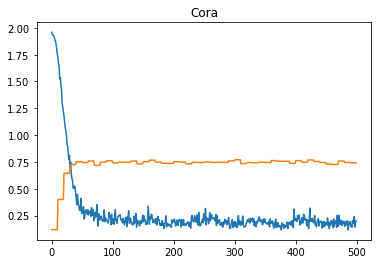

In [30]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

In [17]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

Processing...
Done!


None task, test set size: 140


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


AttributeError: ignored

## Question 1.1: What is the maximum accuracy you could get on test set for GraphSage? (10 points)

Submit your answers on Gradescope.

***Maxiumum Accuracy is 0.79!!!***

## Question 1.2: What is the maximum accuracy you could get on test set for GAT? (10 points)

Submit your answers on Gradescope.

***Maxiumum Accuracy is 0.774!!!***

# 2 DeepSNAP Basics

In previous Colabs we used both of graph class (NetworkX) and tensor (PyG) representations of graphs separately. The graph class `nx.Graph` provides rich analysis and manipulation functionalities, such as the clustering coefficient and PageRank. To feed the graph into the model, we need to transform the graph into tensor representations including edge tensor `edge_index` and node attributes tensors `x` and `y`. But only using tensors (as the graphs formatted in PyG `datasets` and `data`) will make many graph manipulations and analysis less efficient and harder. So, in this Colab we will use DeepSNAP which combines both representations and offers a full pipeline for GNN training / validation / testing.


In general, [DeepSNAP](https://github.com/snap-stanford/deepsnap) is a Python library to assist efficient deep learning on graphs. DeepSNAP features in its support for flexible graph manipulation, standard pipeline, heterogeneous graphs and simple API.

1. DeepSNAP is easy to be used for the sophisticated graph manipulations, such as feature computation, pretraining, subgraph extraction etc. during/before the training.
2. In most frameworks, standard pipelines for node, edge, link, graph-level tasks under inductive or transductive settings are left to the user to code. In practice, there are additional design choices involved (such as how to split dataset for link prediction). DeepSNAP provides such a standard pipeline that greatly saves repetitive coding efforts, and enables fair comparision for models.
3. Many real-world graphs are heterogeneous graphs. But packages support for heterogeneous graphs, including data storage and flexible message passing, is lacking. DeepSNAP provides an efficient and flexible heterogeneous graph that supports both the node and edge heterogeneity.

[DeepSNAP](https://github.com/snap-stanford/deepsnap) is a newly released project and it is still under development. If you find any bugs or have any improvement ideas, feel free to raise issues or create pull requests on the GitHub directly :)

In this Colab, we will focus on DeepSNAP graph manipulations and splitting settings.

## Setup

In [ ]:
!nvidia-smi

Thu Jul 21 10:27:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install deepsnap

In [ ]:
# import torch
# import networkx as nx
# import matplotlib.pyplot as plt

# from deepsnap.graph import Graph
# from deepsnap.batch import Batch
# from deepsnap.dataset import GraphDataset
# from torch_geometric.datasets import Planetoid, TUDataset

# from torch.utils.data import DataLoader

# def visualize(G, color_map=None, seed=123):
#   if color_map is None:
#     color_map = '#c92506'
#   plt.figure(figsize=(8, 8))
#   nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
#                                  label=None, node_color=color_map, node_shape='o', node_size=150)
#   edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
#   if color_map is not None:
#     plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
#     plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
#     plt.legend(prop={'size': 13}, handletextpad=0)
#   nodes.set_edgecolor('black')
#   plt.show()

In [ ]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
# !pip install -q torch-geometric

In [ ]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

In [ ]:
def visualize(G, color_map=None, seed=123):
  if color_map is None:
    color_map ='#c92506'
  plt.figure(figsize=(8, 8))
  nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), label=None, node_color=color_map, node_shape='o', node_size=150)
  edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)

  if color_map is not None:
    plt.scatter([], [], c='#c92506', label='Nodes with label 0', edgecolors='black', s=140)
    plt.scatter([], [], c='#fcec00', label='Nodes with label 1', edgecolors='black', s=140)
    plt.legend(prop={'size': 13}, handletextpad=0)
  nodes.set_edgecolor('black')
  plt.show()

## DeepSNAP Graph

The `deepsnap.graph.Graph` class is the core class of DeepSNAP. It not only represents a graph in tensor format but also references to a graph object from graph manipulation package.

Currently DeepSNAP supports [NetworkX](https://networkx.org/) and [Snap.py](https://snap.stanford.edu/snappy/doc/index.html) as the back end graph manipulation package.

In this Colab, we will use the NetworkX as the back end graph manipulation package.

Lets first try to convert a simple random NetworkX graph to a DeepSNAP graph.

(0, {'node_feature': tensor([0.1397, 0.9584, 0.8948, 0.8922, 0.6466]), 'node_label': tensor(1)})


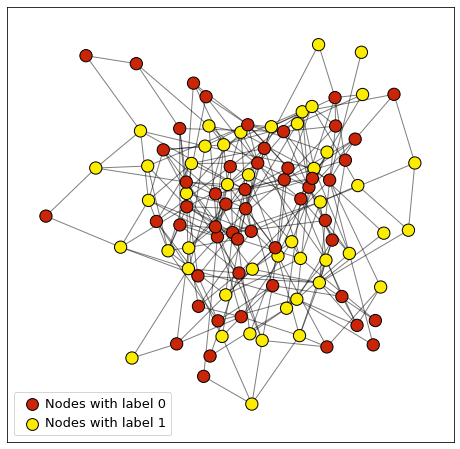

Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])
Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64
Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64
The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manupulation graph


In [ ]:
# num_nodes = 100
# p = 0.05
# seed = 100

# # Generate a networkx random graph
# G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# # Generate some random node features and labels
# node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
# node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

# # Set the random features and labels to G
# nx.set_node_attributes(G, node_feature, name='node_feature')
# nx.set_node_attributes(G, node_label, name='node_label')

# # Print one node example
# for node in G.nodes(data=True):
#   print(node)
#   break

# color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]

# # Visualize the graph
# visualize(G, color_map=color_map)

# # Transform the networkx graph into the deepsnap graph
# graph = Graph(G)

# # Print out the general deepsnap graph information
# print(graph)

# # DeepSNAP will convert node attributes to tensors
# # Notice the type of tensors
# print("Node feature (node_feature) has shape {} and type {}".format(graph.node_feature.shape, graph.node_feature.dtype))
# print("Node label (node_label) has shape {} and type {}".format(graph.node_label.shape, graph.node_label.dtype))

# # DeepSNAP will also generate the edge_index tensor
# print("Edge index (edge_index) has shape {} and type {}".format(graph.edge_index.shape, graph.edge_index.dtype))

# # Different from only storing tensors, deepsnap graph also references to the networkx graph
# # We will discuss why the reference will be helpful later
# print("The DeepSNAP graph has {} as the internal manupulation graph".format(type(graph.G)))

In [ ]:
num_nodes = 100
p = 0.05
seed = 100

# Generate a networkx random graph
G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# Generate some random node features and labels
node_feature = {node : torch.rand([5,]) for node in G.nodes()}
node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

# Set the random features and labels to G
nx.set_node_attributes(G, node_feature, name='node_feature')
nx.set_node_attributes(G, node_label, name='node_label')

# print one node example
for node in G.nodes(data=True):
  print(node)
  break

# num_nodes = 100
# Node의 개수룰 100개로 지정하였고, 그 중에서 하나를 예시로 뽑아내면 이렇게 볼 수 있다.

(0, {'node_feature': tensor([0.8367, 0.0666, 0.0110, 0.8608, 0.6543]), 'node_label': tensor(0)})


In [ ]:
color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]
print(color_map)
print(len(color_map))

['#c92506', '#fcec00', '#c92506', '#fcec00', '#fcec00', '#c92506', '#fcec00', '#fcec00', '#fcec00', '#c92506', '#fcec00', '#c92506', '#c92506', '#c92506', '#fcec00', '#fcec00', '#c92506', '#c92506', '#c92506', '#c92506', '#c92506', '#c92506', '#fcec00', '#c92506', '#c92506', '#c92506', '#fcec00', '#fcec00', '#c92506', '#fcec00', '#fcec00', '#fcec00', '#c92506', '#c92506', '#c92506', '#c92506', '#c92506', '#fcec00', '#fcec00', '#fcec00', '#c92506', '#c92506', '#fcec00', '#c92506', '#fcec00', '#c92506', '#c92506', '#c92506', '#fcec00', '#fcec00', '#c92506', '#c92506', '#fcec00', '#fcec00', '#c92506', '#c92506', '#fcec00', '#c92506', '#fcec00', '#c92506', '#c92506', '#c92506', '#c92506', '#fcec00', '#fcec00', '#fcec00', '#c92506', '#c92506', '#fcec00', '#fcec00', '#c92506', '#c92506', '#c92506', '#fcec00', '#c92506', '#c92506', '#c92506', '#c92506', '#c92506', '#c92506', '#fcec00', '#c92506', '#c92506', '#fcec00', '#fcec00', '#c92506', '#fcec00', '#c92506', '#c92506', '#fcec00', '#c92506'

In [ ]:
print(node[1]['node_label'].item())

0


In [ ]:
print(node[1]['node_label'].item() for node in G.nodes(data=True))

<generator object <genexpr> at 0x7f2939b91bd0>


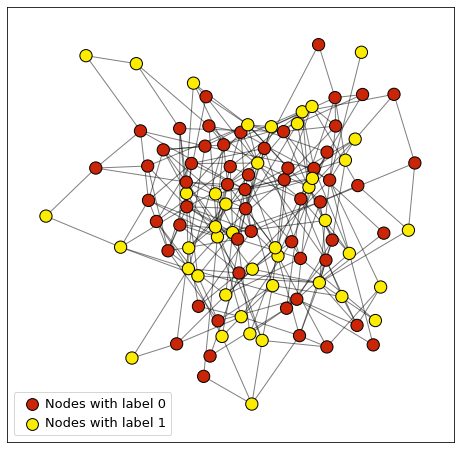

In [ ]:
visualize(G, color_map=color_map)

In [ ]:
graph = Graph(G)
print(graph)

# 밑에 나오는 내역들은 크기라고 볼 수 있다.

Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])


In [ ]:
print(graph.edge_index)

tensor([[ 0,  0,  0,  ..., 96, 97, 99],
        [11, 31, 84,  ..., 94, 94, 98]])


In [ ]:
print(graph.edge_index[0])
print(len(graph.edge_index[0]))

tensor([ 0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
         6,  6,  6,  6,  6,  7,  7,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10,
        11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14,
        14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 21,
        21, 22, 22, 23, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26,
        27, 27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33,
        33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 37, 37, 37, 37, 38, 38, 38,
        38, 38, 39, 40, 40, 41, 41, 42, 42, 43, 43, 43, 43, 44, 44, 45, 45, 45,
        46, 47, 47, 48, 49, 49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 52, 52, 52,
        53, 53, 53, 54, 55, 56, 56, 56, 56, 57, 57, 58, 58, 59, 59, 59, 60, 60,
        60, 61, 62, 62, 62, 63, 63, 65, 

In [ ]:
print(graph.edge_index[1])
print(len(graph.edge_index[1]))

tensor([11, 31, 84,  4, 40, 53, 59, 86, 88, 18, 19, 28, 32, 37, 41, 64, 69, 72,
        84, 97, 99, 45, 60, 83, 97, 24, 26, 29, 57, 63, 49, 56, 57, 69, 89, 95,
        26, 41, 53, 68, 97, 28, 39, 66, 69, 85, 39, 56, 60, 66, 72, 17, 19, 65,
        23, 30, 57, 64, 66, 24, 26, 44, 61, 68, 96, 55, 60, 78, 93, 95, 97, 29,
        30, 40, 50, 59, 90, 43, 44, 61, 69, 94, 58, 59, 86, 99, 51, 63, 66, 92,
        20, 34, 46, 82, 88, 21, 30, 87, 88, 94, 95, 37, 43, 96, 25, 41, 53, 73,
        77, 58, 75, 25, 26, 33, 64, 71, 79, 94, 99, 36, 42, 43, 51, 73, 85, 86,
        61, 62, 85, 55, 76, 78, 31, 33, 67, 98, 82, 83, 60, 82, 65, 83, 58, 70,
        81, 85, 43, 56, 74, 87, 76, 83, 87, 88, 50, 55, 75, 80, 94, 48, 58, 78,
        86, 88, 74, 65, 88, 67, 96, 46, 47, 58, 62, 92, 93, 52, 54, 83, 93, 98,
        89, 77, 90, 76, 50, 62, 66, 90, 55, 63, 68, 71, 77, 85, 98, 58, 82, 96,
        68, 75, 87, 56, 83, 58, 77, 78, 79, 71, 89, 60, 97, 66, 72, 94, 79, 89,
        94, 65, 63, 72, 91, 66, 70, 84, 

In [ ]:
print(graph.edge_index[0] * graph.edge_index[1])

tensor([   0,    0,    0,    4,   40,   53,   59,   86,   88,   36,   38,   56,
          64,   74,   82,  128,  138,  144,  168,  194,  198,  135,  180,  249,
         291,   96,  104,  116,  228,  252,  245,  280,  285,  345,  445,  475,
         156,  246,  318,  408,  582,  196,  273,  528,  552,  680,  351,  504,
         540,  594,  648,  170,  190,  650,  253,  330,  627,  704,  726,  288,
         312,  528,  732,  816, 1152,  715,  780, 1014, 1209, 1235, 1261,  406,
         420,  560,  700,  826, 1260,  645,  660,  915, 1035, 1410,  928,  944,
        1376, 1584,  867, 1071, 1122, 1564,  360,  612,  828, 1476, 1584,  399,
         570, 1653, 1672, 1786, 1805,  740,  860, 1920,  525,  861, 1113, 1533,
        1617, 1276, 1650,  575,  624,  792, 1536, 1704, 1975, 2350, 2475,  936,
        1092, 1118, 1326, 1898, 2210, 2236, 1647, 1674, 2295, 1540, 2128, 2184,
         899,  957, 1943, 2842, 2460, 2490, 1860, 2542, 2080, 2656, 1914, 2310,
        2673, 2805, 1462, 1904, 2516, 29

In [ ]:
print(graph.node_feature)

tensor([[0.8367, 0.0666, 0.0110, 0.8608, 0.6543],
        [0.7814, 0.3997, 0.0480, 0.6380, 0.0342],
        [0.4713, 0.0418, 0.1015, 0.2217, 0.0678],
        [0.1362, 0.3212, 0.1829, 0.1548, 0.7602],
        [0.0392, 0.6276, 0.1785, 0.9382, 0.5037],
        [0.1176, 0.9574, 0.3948, 0.7214, 0.5786],
        [0.7399, 0.7820, 0.0332, 0.7258, 0.0215],
        [0.9164, 0.9645, 0.0870, 0.7919, 0.2709],
        [0.7579, 0.4585, 0.4706, 0.0957, 0.1502],
        [0.1792, 0.6122, 0.4977, 0.2551, 0.0400],
        [0.3620, 0.2258, 0.9016, 0.9588, 0.4159],
        [0.7911, 0.8586, 0.5544, 0.6587, 0.3524],
        [0.3117, 0.1496, 0.5642, 0.2098, 0.5307],
        [0.3904, 0.5385, 0.8052, 0.5780, 0.8447],
        [0.6633, 0.2719, 0.2412, 0.8364, 0.3810],
        [0.2512, 0.3118, 0.3016, 0.1398, 0.9448],
        [0.6961, 0.5675, 0.6475, 0.6307, 0.4927],
        [0.1980, 0.4876, 0.6145, 0.7356, 0.2470],
        [0.7337, 0.0578, 0.0167, 0.1325, 0.2890],
        [0.1017, 0.9269, 0.2451, 0.6742, 0.0886],


In [ ]:
print(graph.node_label)

tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0])


In [ ]:
print(graph.node_label_index)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


In [ ]:
# DeepSNAP will convert node attributes to tensors
# Notice the type of tensors
print(f'Node feature (node_feature) has shape {graph.node_feature.shape} and type {graph.node_feature.dtype}')
print(f'Node label (node_label) has shape {graph.node_label.shape} and type {graph.node_label.dtype}')

Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64


In [ ]:
# DeepSNAP will also generate the edge_index tensor
print(f'Edge index (edge_index) has shape {graph.edge_index.shape} and type {graph.edge_index.dtype}')

Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64


In [ ]:
# Different from only strong tensors. 
# DeepSNAP graph also references to the networkx graph
# We will discuss why the reference will be helpful later.

print(f'The DeepSNAP graph has {type(graph.G)} as the internal manipulation graph.')

The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manipulation graph.


In DeepSNAP we have three levels of attributes. In this example, we have the **node level** attributes including `node_feature` and `node_label`. The other two levels of attributes are graph and edge attributes. The usage is similar to the node level one except that the feature becomes `edge_feature` or `graph_feature` and label becomes `edge_label` or `graph_label` etc.

Similar to the NetworkX graph, we can easily get some basic information of the graph through class properties directly.

In [ ]:
# Number of nodes
print("The random graph has {} nodes".format(graph.num_nodes))

# Number of edges
print("The random graph has {} edges".format(graph.num_edges))

The random graph has 100 nodes
The random graph has 262 edges


# ***Node, Edge, Graph -> NEG (Node, Edge, Graph)***

In [ ]:
print(f'The random graph has {graph.num_nodes} nodes.')
print(f'The random graph has {graph.num_edges} edges.')

The random graph has 100 nodes.
The random graph has 262 edges.


In [ ]:
print(f'The random graph has {graph.num_graph_features} graph features.')

The random graph has 0 graph features.


In [ ]:
# Node
print(graph.num_nodes)
print(graph.num_node_features)
print(graph.num_node_labels)

100
5
2


In [ ]:
# Edge
print(graph.num_edge_features)
print(graph.num_edge_labels)
print(graph.num_edges)

0
0
262


In [ ]:
# Graph
print(graph.num_graph_features)
print(graph.num_graph_labels)

0
0


DeepSNAP also provides functions that can automatically transform the PyG datasets into a list of DeepSNAP graphs.

Here we transform the CORA dataset into a list of DeepSNAP graphs.

In [ ]:
# root = './tmp/cora'
# name = 'Cora'

# # The Cora dataset
# pyg_dataset= Planetoid(root, name)

# # PyG dataset to a list of deepsnap graphs
# graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# # Get the first deepsnap graph (CORA only has one graph)
# graph = graphs[0]
# print(graph)

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


Processing...
Done!


In [ ]:
root = './tmp/cora'
name = 'Cora'

# The Cora Dataset
pyg_dataset = Planetoid(root, name)

# PyG dataset to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Get the 1st deepsnap graph (CORA only has one graph)
graph = graphs[0]
print(graph)

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


Processing...
Done!


# Cora Dataset
- Node : 머신러닝 논문
- Edge : 논문 쌍 간의 인용

## 이 논문은 인용 그래프를 나타낸다고 할 수 있다.
- Node : Node Classification : 논문 분류 (7개의 클래스)
- Edge : Link Prediction : 인용 여부

In [ ]:
print(graphs[0])

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


In [ ]:
print(graphs[0].edge_index)
print(graphs[0].edge_index.shape)

tensor([[   0,    0,    0,  ..., 2688, 2695, 2707],
        [ 633, 1862, 2582,  ..., 2687, 2694, 2706]])
torch.Size([2, 10556])


In [ ]:
print(graphs[0].edge_index[0])
print(graphs[0].edge_index[1])
print(len(graphs[0].edge_index[0]))

tensor([   0,    0,    0,  ..., 2688, 2695, 2707])
tensor([ 633, 1862, 2582,  ..., 2687, 2694, 2706])
10556


In [ ]:
print(graphs[0].edge_label_index)

tensor([[   0,    0,    0,  ..., 2688, 2695, 2707],
        [ 633, 1862, 2582,  ..., 2687, 2694, 2706]])


In [ ]:
print(graphs[0].node_feature)
print(graphs[0].node_feature.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([2708, 1433])


In [ ]:
print(graphs[0].node_feature[0])
print(graphs[0].node_feature[-1])

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [ ]:
print(graphs[0].node_label)

tensor([3, 4, 4,  ..., 3, 3, 3])


In [ ]:
print(graphs[0].node_label_index)

tensor([   0,    1,    2,  ..., 2705, 2706, 2707])


In [ ]:
print(len(graphs[0].node_label_index))

2708


## Question 2.1: What is the number of classes and number of features in the CORA graph? (5 points)

Submit your answers on Gradescope.

In [ ]:
# def get_num_node_classes(graph):
#   # TODO: Implement this function that takes a deepsnap graph object
#   # and return the number of node classes of that graph.

#   num_node_classes = 0

#   ############# Your code here #############
#   ## (~1 line of code)
#   ## Note
#   ## 1. Colab autocomplete functionality might be useful
#   ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html

#   num_node_classes = graph.num_node_labels

#   ##########################################

#   return num_node_classes

# def get_num_node_features(graph):
#   # TODO: Implement this function that takes a deepsnap graph object
#   # and return the number of node features of that graph.

#   num_node_features = 0

#   ############# Your code here #############
#   ## (~1 line of code)
#   ## Note
#   ## 1. Colab autocomplete functionality might be useful
#   ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html

#   num_node_features = graph.num_node_features
#   ##########################################

#   return num_node_features

# num_node_classes = get_num_node_classes(graph)
# num_node_features = get_num_node_features(graph)
# print("{} has {} classes".format(name, num_node_classes))
# print("{} has {} features".format(name, num_node_features))

Cora has 7 classes
Cora has 1433 features


In [ ]:
def get_num_node_classes(graph):
  num_node_classes = graph.num_node_labels
  return num_node_classes

def get_num_node_features(graph):
  num_node_features = graph.num_node_features
  return num_node_features

In [ ]:
num_node_classes = get_num_node_classes(graph)
num_node_features = get_num_node_features(graph)

print(f'{name} has {num_node_classes} classes.')
print(f'{name} has {num_node_features} features.')

Cora has 7 classes.
Cora has 1433 features.


## DeepSNAP Dataset

Now, lets talk about DeepSNAP dataset. A `deepsnap.dataset.GraphDataset` contains a list of `deepsnap.graph.Graph` objects. In addition to list of graphs, you can also specify what task the dataset will be used on, such as node level task (`task=node`), edge level task (`task=link_pred`) and graph level task (`task=graph`).

It also contains many other useful parameters during initialization and other functinoalities. If you are interested, you can take a look at the [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset).

Lets now use COX2 dataset which contains a list of graphs and specify the task to `graph` when we initialize the DeepSNAP dataset.

In [ ]:
# root = './tmp/cox2'
# name = 'COX2'

# # Load the dataset through PyG
# pyg_dataset = TUDataset(root, name)

# # Convert to a list of deepsnap graphs
# graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# # Convert list of deepsnap graphs to deepsnap dataset with specified task=graph
# dataset = GraphDataset(graphs, task='graph')
# print(dataset)

Extracting tmp/cox2/COX2/COX2.zip
Processing...
Done!


GraphDataset(467)


In [ ]:
root = './tmp/cox2'
name = 'COX2'

# Load the dataset through PyG
pyg_dataset = TUDataset(root, name)

# Convert to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Convert list of deepsnap graphs to deepsnap dataset with specified task = graph
dataset = GraphDataset(graphs, task='graph')
print(dataset)

Extracting tmp/cox2/COX2/COX2.zip
Processing...
Done!


GraphDataset(467)


## Question 2.2: What is the label of the graph (index 100 in the COX2 dataset)? (5 points)

Submit your answers on Gradescope.

In [ ]:
# def get_graph_class(dataset, idx):
#   # TODO: Implement this function that takes a deepsnap dataset object,
#   # the index of the graph in the dataset, and returns the class/label 
#   # of the graph (in integer).

#   label = -1

#   ############# Your code here ############
#   ## (~1 line of code)
#   ## Note
#   ## 1. The label refers to the graph-level attribute
#   label = dataset[idx].graph_label

#   #########################################

#   return label

# graph_0 = dataset[0]
# print(graph_0)
# idx = 100
# label = get_graph_class(dataset, idx)
# print('Graph with index {} has label {}'.format(idx, label))

Graph(G=[], edge_index=[2, 82], edge_label_index=[2, 82], graph_label=[1], node_feature=[39, 35], node_label_index=[39], task=[])
Graph with index 100 has label tensor([0])


In [ ]:
def get_graph_class(dataset, idx):
  label = dataset[idx].graph_label
  return label

In [ ]:
graph_0 = dataset[0]
print(graph_0)

Graph(G=[], edge_index=[2, 82], edge_label_index=[2, 82], graph_label=[1], node_feature=[39, 35], node_label_index=[39], task=[])


In [ ]:
idx = 100
label = get_graph_class(dataset, idx)
print(f'Graph with index {idx} has label {label}')

Graph with index 100 has label tensor([0])


In [ ]:
idx = 200
label = get_graph_class(dataset, idx)
print(f'Graph with index {idx} has label {label}')

Graph with index 200 has label tensor([0])


## Question 2.3: What is the number of edges for the graph (index 200 in the COX2 dataset)? (5 points)

Submit your answers on Gradescope.

In [ ]:
# def get_graph_num_edges(dataset, idx):
#   # TODO: Implement this function that takes a deepsnap dataset object,
#   # the index of the graph in dataset, and returns the number of 
#   # edges in the graph (in integer).

#   num_edges = 0

#   ############# Your code here ############
#   ## (~1 lines of code)
#   ## Note
#   ## 1. You can use the class property directly
  
#   num_edges = dataset[idx].num_edges

#   #########################################

#   return num_edges

# idx = 200
# num_edges = get_graph_num_edges(dataset, idx)
# print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 49 edges


In [ ]:
def get_graph_num_edges(dataset, idx):
  num_edges = dataset[idx].num_edges
  return num_edges

In [ ]:
idx = 100
num_edges = get_graph_num_edges(dataset, idx)
print(f'Graph with index {idx} has {num_edges} edges')

Graph with index 100 has 39 edges


In [ ]:
idx = 200
num_edges = get_graph_num_edges(dataset, idx)
print(f'Graph with index {idx} has {num_edges} edges')

Graph with index 200 has 49 edges


# 3 DeepSNAP Advanced

We have learned the basic use of DeepSNAP graph and dataset :)

Lets move on to some more advanced functionalities.

In this section we will use DeepSNAP for faeture computation and transductive/inductive splittings.

## Setup

In [ ]:
# import torch
# import networkx as nx
# import matplotlib.pyplot as plt

# from deepsnap.graph import Graph
# from deepsnap.batch import Batch
# from deepsnap.dataset import GraphDataset
# from torch_geometric.datasets import Planetoid, TUDataset

# from torch.utils.data import DataLoader

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

## Data Split in Graphs

Data splitting in graphs can be much harder than that in CV or NLP.

In general, the data splitting in graphs can be divided into two settings, **inductive** and **transductive**.

## Inductive Split

As what we have learned in the lecture, inductive setting will split multiple graphs into each training/valiation and test sets.

Here is an example of DeepSNAP inductive splitting for a list of graphs in the graph level task (graph classification etc.)

In [ ]:
# root = './tmp/cox2'
# name = 'COX2'

# pyg_dataset = TUDataset(root, name)

# graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# # Here we specify the task as graph-level task such as graph classification
# task = 'graph'
# dataset = GraphDataset(graphs, task=task)

# # Specify transductive=False (inductive)
# dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

# print("COX2 train dataset: {}".format(dataset_train))
# print("COX2 validation dataset: {}".format(dataset_val))
# print("COX2 test dataset: {}".format(dataset_test))

COX2 train dataset: GraphDataset(373)
COX2 validation dataset: GraphDataset(46)
COX2 test dataset: GraphDataset(48)


In [ ]:
root = './tmp/cox2'
name = 'COX2'

pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as graph-level task such as graph classification
task = 'graph'
dataset = GraphDataset(graphs, task=task)

# Specify transductive=False (inductive)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

print(f'COX2 Train Dataset : {dataset_train}')
print(f'COX2 Validation Dataset : {dataset_val}')
print(f'COX2 Test Dataset : {dataset_test}')

COX2 Train Dataset : GraphDataset(373)
COX2 Validation Dataset : GraphDataset(46)
COX2 Test Dataset : GraphDataset(48)


# Transductive Split

In transductive setting, the training /validation / test sets are on the same graph.

Here we transductively split the CORA graph in the node level task.

(Notice that in DeepSNAP default setting the split is random, but you can also make a fixed split by specifying fixed_split=True when loading the dataset from PyG or changing the node_label_index directly).

In [ ]:
# root = './tmp/cora'
# name = 'Cora'

# pyg_dataset = Planetoid(root, name)

# graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# # Here we specify the task as node-level task such as node classification
# task = 'node'

# dataset = GraphDataset(graphs, task=task)

# # Specify we want the transductive splitting
# dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

# print("Cora train dataset: {}".format(dataset_train))
# print("Cora validation dataset: {}".format(dataset_val))
# print("Cora test dataset: {}".format(dataset_test))

# print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

# # The nodes in each set can be find in node_label_index
# print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
# print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
# print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)
Original Cora has 2708 nodes
After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


In [ ]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as node-level task such as node classification
task = 'node'
dataset = GraphDataset(graphs, task=task)

# Specify we want the transductive splitting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio = [0.8, 0.1, 0.1])

print(f'Cora train dataset : {dataset_train}')
print(f'Cora validation dataset : {dataset_val}')
print(f'Cora test dataset : {dataset_test}')

Cora train dataset : GraphDataset(1)
Cora validation dataset : GraphDataset(1)
Cora test dataset : GraphDataset(1)


In [ ]:
print(f'Original Cora has {dataset.num_nodes[0]} nodes')

Original Cora has 2708 nodes


In [ ]:
# The nodes in each set can be find in node_label_index
print(f'After the split, Cora has {dataset_train[0].node_label_index.shape[0]} training nodes')
print(f'After the split, Cora has {dataset_val[0].node_label_index.shape[0]} validation nodes')
print(f'After the split, Cora has {dataset_test[0].node_label_index.shape[0]} test nodes')

After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


In [ ]:
2166 + 270 + 272

2708

## Edge Level Split

Compared to the node and graph level splitting, edge level splitting is a little bit tricky ;)

Usually in edge level splitting, we need to sample negative edges, split positive edges into different datasets, split training edges into message passing edges and supervision edges, and resample the negative edges during the training etc.

### All Mode

Now lets start with a simpler edge level splitting mode, the `edge_train_mode="all"` mode in DeepSNAP.

In [ ]:
# root = './tmp/cora'
# name = 'Cora'

# pyg_dataset = Planetoid(root, name)

# graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# # Specify task as link_pred for edge-level task
# task = 'link_pred'

# # Specify the train mode, "all" mode is default for deepsnap dataset
# edge_train_mode = "all"

# dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# # Transductive link prediction split
# dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

# print("Cora train dataset: {}".format(dataset_train))
# print("Cora validation dataset: {}".format(dataset_val))
# print("Cora test dataset: {}".format(dataset_test))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# edge_train_mode = 'all'

root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, 'all' mode is default for deepsnap dataset.
edge_train_mode ='all'

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print(f'Cora Train Dataset : {dataset_train}')
print(f'Cora Validation Dataset : {dataset_val}')
print(f'Cora Test Dataset : {dataset_test}')

Cora Train Dataset : GraphDataset(1)
Cora Validation Dataset : GraphDataset(1)
Cora Test Dataset : GraphDataset(1)


In DeepSNAP, the indices of supervision edges are stored in `edge_label_index` tensor and the corresponding edge labels are stored in `edge_label` tensor.

In [ ]:
# print("Original Cora graph has {} edges".format(dataset[0].num_edges))
# print("Because Cora graph is undirected, the original edge_index has shape {}".format(dataset[0].edge_index.shape))

# print("The training set has message passing edge index shape {}".format(dataset_train[0].edge_index.shape))
# print("The training set has supervision edge index shape {}".format(dataset_train[0].edge_label_index.shape))

# print("The validation set has message passing edge index shape {}".format(dataset_val[0].edge_index.shape))
# print("The validation set has supervision edge index shape {}".format(dataset_val[0].edge_label_index.shape))

# print("The test set has message passing edge index shape {}".format(dataset_test[0].edge_index.shape))
# print("The test set has supervision edge index shape {}".format(dataset_test[0].edge_label_index.shape))

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])
The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])
The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In [ ]:
print(f'Original Cora graph has {dataset[0].num_edges} edges')
print(f'Because Cora graph is undirected, the original edge_index has shape {dataset[0].edge_index.shape}')
print(5278 * 2)

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
10556


In [ ]:
print(f'The training set has message passing edge index shape {dataset_train[0].edge_index.shape}')
print(f'The training set has supervision edge index shape {dataset_train[0].edge_label_index.shape}')

The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])


In [ ]:
print(f'The validation set has message passing edge index shape {dataset_val[0].edge_index.shape}')
print(f'The validation set has supervision edge index shape {dataset_val[0].edge_label_index.shape}')

The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])


In [ ]:
print(f'The test set has message passing edge index shape {dataset_test[0].edge_index.shape}')
print(f'The test set has supervision edge index shape {dataset_test[0].edge_label_index.shape}')

The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


We can see that both training and validation sets have the same message passing edges (`edge_index`) in the `all` mode. Also, in training set, the postive supervision edges (`edge_label_index`) are same with the message passing edges. However, in the test set the message passing edges are the combination of message passing edges from training and validation sets.

Notice that the `edge_label` and `edge_label_index` have included the negative edges (default number of negative edges is same with the number of positive edges).

Now, lets implement a function that checks whether two edge index tensors are disjoint and explore more edge splitting properties by using that function.

## Question 3.1 - 3.5: Implement the function that checks whether two edge_index tensors are disjoint. Then answer the True/False questions below. (5 points)

Submit your answers on Gradescope.

In [ ]:
# def edge_indices_disjoint(edge_index_1, edge_index_2):
#   # TODO: Implement this function that takes two edge index tensors,
#   # and returns whether these two edge index tensors are disjoint.
#   disjoint = None

#   ############# Your code here ############
#   ## (~5 lines of code)
#   ## Note
#   ## 1. Here disjoint means that there is no single edge belongs to either edge index tensors
#   ## 2. You do not need to consider the undirected case. For example, if edge_index_1 contains
#   ## edge (a, b) and edge_index_2 contains edge (b, a). We will treat them as disjoint in this
#   ## function.

#   disjoint = True

#   edge_set_1 = set([t for t in edge_index_1.reshape(-1, 2)])

#   for t in edge_index_2.reshape(-1, 2):
#     if t in edge_set_1:
#       disjoint = False
#       break

#   #########################################

#   return disjoint

In [ ]:
def edge_indices_disjoint(edge_index_1, edge_index_2):
  disjoint = True
  edge_set_1 = set([t for t in edge_index_1.reshape(-1, 2)])
  
  for t in edge_index_2.reshape(-1, 2):
    if t in edge_set_1:
      disjoint = False
      break
  return disjoint

In [ ]:
# num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
# train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
# train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
# print("3.1 Training (supervision) positve and negative edges are disjoint = {}"\
#         .format(edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)))

# num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
# val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
# val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
# print("3.2 Validation (supervision) positve and negative edges are disjoint = {}"\
#         .format(edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)))

# num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
# test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
# test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
# print("3.3 Test (supervision) positve and negative edges are disjoint = {}"\
#         .format(edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)))

# print("3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = {}"\
#         .format(edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)))
# print("3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = {}"\
#         .format(edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)))

3.1 Training (supervision) positve and negative edges are disjoint = True
3.2 Validation (supervision) positve and negative edges are disjoint = True
3.3 Test (supervision) positve and negative edges are disjoint = True
3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = True
3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = True


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In [ ]:
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
print(f'3.1 Training (supervision) positive and negative edges are disjoint = {edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)}')

3.1 Training (supervision) positive and negative edges are disjoint = True


In [ ]:
num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
print(f'3.2 Validation (supervision) positive and negative edges are disjoint = {edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)}')

3.2 Validation (supervision) positive and negative edges are disjoint = True


In [ ]:
num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
print(f'3.3 Test (supervision) positive and negative edges are disjoint = {edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)}')

3.3 Test (supervision) positive and negative edges are disjoint = True


In [ ]:
print(f'3.4 Test (supervision) positive and validation (supervision) positive edges are disjoint = {edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)}')

3.4 Test (supervision) positive and validation (supervision) positive edges are disjoint = True


In [ ]:
print(f'3.5 Validation (supervision) positive and training (supervision) positive edges are disjoint = {edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)}')

3.5 Validation (supervision) positive and training (supervision) positive edges are disjoint = True


### Disjoint Mode

Now lets look at a relatively more complex transductive edge split setting, which is the `edge_train_mode="disjoint"` mode in DeepSNAP (also the transductive link prediction splitting talked in the lecture)

In [ ]:
# edge_train_mode = "disjoint"

# dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
# orig_edge_index = dataset[0].edge_index
# dataset_train, dataset_val, dataset_test = dataset.split(
#     transductive=True, split_ratio=[0.8, 0.1, 0.1])

# train_message_edge_index = dataset_train[0].edge_index
# train_sup_edge_index = dataset_train[0].edge_label_index
# val_sup_edge_index = dataset_val[0].edge_label_index
# test_sup_edge_index = dataset_test[0].edge_label_index

# print("The edge index of original graph has shape: {}".format(orig_edge_index.shape))
# print("The edge index of training message edges has shape: {}".format(train_message_edge_index.shape))
# print("The edge index of training supervision edges has shape: {}".format(train_sup_edge_index.shape))
# print("The edge index of validation message edges has shape: {}".format(dataset_val[0].edge_index.shape))
# print("The edge index of validation supervision edges has shape: {}".format(val_sup_edge_index.shape))
# print("The edge index of test message edges has shape: {}".format(dataset_test[0].edge_index.shape))
# print("The edge index of test supervision edges has shape: {}".format(test_sup_edge_index.shape))

The edge index of original graph has shape: torch.Size([2, 10556])
The edge index of training message edges has shape: torch.Size([2, 6754])
The edge index of training supervision edges has shape: torch.Size([2, 3380])
The edge index of validation message edges has shape: torch.Size([2, 8444])
The edge index of validation supervision edges has shape: torch.Size([2, 2108])
The edge index of test message edges has shape: torch.Size([2, 9498])
The edge index of test supervision edges has shape: torch.Size([2, 2116])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In [ ]:
edge_train_mode = 'disjoint'

dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
orig_edge_index = dataset[0].edge_index

dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_message_edge_index = dataset_train[0].edge_index
train_sup_edge_index = dataset_train[0].edge_label_index
val_sup_edge_index = dataset_val[0].edge_label_index
test_sup_edge_index = dataset_test[0].edge_label_index

print("The edge index of original graph has shape: {}".format(orig_edge_index.shape))
print("The edge index of training message edges has shape: {}".format(train_message_edge_index.shape))
print("The edge index of training supervision edges has shape: {}".format(train_sup_edge_index.shape))
print("The edge index of validation message edges has shape: {}".format(dataset_val[0].edge_index.shape))
print("The edge index of validation supervision edges has shape: {}".format(val_sup_edge_index.shape))
print("The edge index of test message edges has shape: {}".format(dataset_test[0].edge_index.shape))
print("The edge index of test supervision edges has shape: {}".format(test_sup_edge_index.shape))

The edge index of original graph has shape: torch.Size([2, 10556])
The edge index of training message edges has shape: torch.Size([2, 6754])
The edge index of training supervision edges has shape: torch.Size([2, 3380])
The edge index of validation message edges has shape: torch.Size([2, 8444])
The edge index of validation supervision edges has shape: torch.Size([2, 2108])
The edge index of test message edges has shape: torch.Size([2, 9498])
The edge index of test supervision edges has shape: torch.Size([2, 2116])


You can see that the training / validation message passing edges and training supervision edges are splitted differently in those two modes!

### Resample Negative Edges

During each training iteration, we usually need to resample the negative edges.

Below we print the training and validation sets negative edges in two training iterations.

You should find that the negative edges in training set will be resampled.

In [ ]:
# dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
# datasets = {}
# follow_batch = []
# datasets['train'], datasets['val'], datasets['test'] = dataset.split(
#     transductive=True, split_ratio=[0.8, 0.1, 0.1])
# dataloaders = {
#   split: DataLoader(
#     ds, collate_fn=Batch.collate(follow_batch),
#     batch_size=1, shuffle=(split=='train')
#   )
#   for split, ds in datasets.items()
# }
# neg_edges_1 = None
# for batch in dataloaders['train']:
#   num_edges = batch.edge_label_index.shape[1] // 2
#   neg_edges_1 = batch.edge_label_index[:, num_edges:]
#   print("First iteration training negative edges:")
#   print(neg_edges_1)
#   break
# neg_edges_2 = None
# for batch in dataloaders['train']:
#   num_edges = batch.edge_label_index.shape[1] // 2
#   neg_edges_2 = batch.edge_label_index[:, num_edges:]
#   print("Second iteration training negative edges:")
#   print(neg_edges_2)
#   break

# neg_edges_1 = None
# for batch in dataloaders['val']:
#   num_edges = batch.edge_label_index.shape[1] // 2
#   neg_edges_1 = batch.edge_label_index[:, num_edges:]
#   print("First iteration validation negative edges:")
#   print(neg_edges_1)
#   break
# neg_edges_2 = None
# for batch in dataloaders['val']:
#   num_edges = batch.edge_label_index.shape[1] // 2
#   neg_edges_2 = batch.edge_label_index[:, num_edges:]
#   print("Second iteration validation negative edges:")
#   print(neg_edges_2)
#   break

First iteration training negative edges:
tensor([[1408, 1078,  831,  ..., 1967,  205, 2052],
        [1160, 2500, 1033,  ..., 2245, 1755,  152]])
Second iteration training negative edges:
tensor([[1790,   52,  494,  ...,  403, 2252, 1561],
        [1803,  109, 2180,  ..., 2293,  478, 2465]])
First iteration validation negative edges:
tensor([[1175, 1920, 2521,  ...,  478, 1735,  204],
        [2307,  568, 1366,  ...,  110, 2162,  632]])
Second iteration validation negative edges:
tensor([[1175, 1920, 2521,  ...,  478, 1735,  204],
        [2307,  568, 1366,  ...,  110, 2162,  632]])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In [ ]:
dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
datasets = {}
follow_batch = []
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])
dataloaders = {
  split: DataLoader(
    ds, collate_fn=Batch.collate(follow_batch),
    batch_size=1, shuffle=(split=='train')
  )
  for split, ds in datasets.items()
}
neg_edges_1 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration training negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration training negative edges:")
  print(neg_edges_2)
  break

neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration validation negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration validation negative edges:")
  print(neg_edges_2)
  break

First iteration training negative edges:
tensor([[ 302,   66,  360,  ...,  858, 2124, 1414],
        [2033, 1220, 2119,  ...,  893, 1866, 1389]])
Second iteration training negative edges:
tensor([[1523,  835,  728,  ..., 1949, 2058,  446],
        [1153, 2406, 2113,  ...,  647,  942,  438]])
First iteration validation negative edges:
tensor([[2273, 1375, 1704,  ..., 2197, 1189,  828],
        [1666, 1133,  650,  ..., 2223, 1256, 2208]])
Second iteration validation negative edges:
tensor([[2273, 1375, 1704,  ..., 2197, 1189,  828],
        [1666, 1133,  650,  ..., 2223, 1256, 2208]])


If you are interested in more graph splitting settings, please refer to the DeepSNAP dataset [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html).

## Graph Transformation and Feature Computation

The other DeepSNAP core functionality is graph transformation / feature computation.

In DeepSNAP, we divide graph transformation / feature computation into two different types. One is the transformation before training (transform the whole dataset before training directly) and another one is the transformation during training (transform batches of graphs).

Here is an example that uses NetworkX back end to calculate the PageRank value and update the value to tensors before the training (transform the dataset).

In [ ]:
# def pagerank_transform_fn(graph):

#   # Get the referenced networkx graph
#   G = graph.G

#   # Calculate the pagerank by using networkx
#   pr = nx.pagerank(G)

#   # Transform the pagerank values to tensor
#   pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
#   pr_feature = pr_feature.view(graph.num_nodes, 1)

#   # Concat the pagerank values to the node feature
#   graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

# root = './tmp/cox2'
# name = 'COX2'
# pyg_dataset = TUDataset(root, name)
# graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
# dataset = GraphDataset(graphs, task='graph')
# print("Number of features before transformation: {}".format(dataset.num_node_features))
# dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
# print("Number of features after transformation: {}".format(dataset.num_node_features))

Number of features before transformation: 35
Number of features after transformation: 36


## Question 3.6: Implement the transformation below and report the clustering coefficient of the node (index 3) of the graph (index 406) in the COX2 dataset. Rounded the answer to two decimal places. (5 points)

In [ ]:
def cluster_transform_fn(graph):
  # TODO: Implement this function that takes an deepsnap graph object,
  # transform the graph by adding nodes clustering coefficient into the 
  # graph.node_feature

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Compute the clustering coefficient value for each node and
  ## concat them to the last dimension of graph.node_feature

  # Get the referenced networkx graph
  G = graph.G
  
  # Calculate the clustering coefficient by using networkx
  cc = nx.clustering(G)

  # Transform the clustering coefficient by using networkx
  cc_feature = torch.tensor([cc[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  cc_feature = cc_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, cc_feature], dim=-1)

  #########################################

root = './cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')

# Transform the dataset
dataset.apply_transform(cluster_transform_fn, update_tensor=False)

node_idx = 3
graph_idx = 406
node_feature = dataset[graph_idx].node_feature

print("The node has clustering coefficient: {}".format(round(node_feature[node_idx][-1].item(), 2)))

Extracting cox2/COX2/COX2.zip
Processing...
Done!


The node has clustering coefficient: 0.17


Apart from transforming the dataset, DeepSNAP can also transform the graph (usually the `deepsnap.batch.Batch`) during each training iteration.

Also, DeepSNAP supports the synchronization of the transformation between the referenced graph objects and tensor representations. For example, you can just update the NetworkX graph object in the transform function, and by specifying `update_tensor=True` the internal tensor representations will be automatically updated.

For more information, please refer to the DeepSNAP [documentation](https://snap.stanford.edu/deepsnap/).

# 4 Edge Level Prediction

From last section, we know how DeepSNAP transductive split the edges in the link prediction task.

Now lets use DeepSNAP and PyG together to implement a edge level prediction (link prediction) model!

In [ ]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = None

        ############# Your code here #############
        ## (~1 line of code)
        ## Note
        ## 1. Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = nn.BCEWithLogitsLoss()

        ##########################################

        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Your code here #############
        ## (~6 line of code)
        ## Note
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source nodes and destination nodes
        ## by using the edge_label_index and compute the similarity of each pair
        ## by dot product

        out = self.conv1(node_feature, edge_index)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout)
        out = self.conv2(out, edge_index)
        out = out[edge_label_index[0]] * out[edge_label_index[1]]
        pred = torch.sum(out, -1)
        
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [ ]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Your code here #############
            ## (~6 lines of code)
            ## Note
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters
            
            optimizer.zero_grad()
            pred = model(batch)
            loss = model.loss(pred, batch.edge_label.float())
            loss.backward()
            optimizer.step()

            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0

    ############# Your code here #############
    ## (~5 lines of code)
    ## Note
    ## 1. Loop through batches in the dataloader
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ## 5. Edge labels are stored in batch.edge_label

    for i, batch in enumerate(dataloaders['test']):
      batch.to(args['device'])
      pred = model(batch)
      pred = torch.sigmoid(pred)
      score += roc_auc_score(batch.edge_label.cpu().detach().numpy(), pred.cpu().detach().numpy())

    score /= len(dataloaders['test'])
    
    ##########################################
 
    return score

In [ ]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [ ]:
pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 001, Train: 0.5475, Val: 0.5314, Test: 0.5282, Loss: 0.6930440664291382
Epoch: 002, Train: 0.5431, Val: 0.5600, Test: 0.5385, Loss: 0.6931257843971252
Epoch: 003, Train: 0.5396, Val: 0.5424, Test: 0.5611, Loss: 0.6930007934570312


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 004, Train: 0.5426, Val: 0.5568, Test: 0.5420, Loss: 0.6930332779884338
Epoch: 005, Train: 0.5351, Val: 0.5305, Test: 0.5260, Loss: 0.6931023001670837
Epoch: 006, Train: 0.5392, Val: 0.5510, Test: 0.5408, Loss: 0.693087100982666


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 007, Train: 0.5401, Val: 0.5440, Test: 0.5424, Loss: 0.6931098699569702
Epoch: 008, Train: 0.5403, Val: 0.5343, Test: 0.5431, Loss: 0.693027138710022
Epoch: 009, Train: 0.5520, Val: 0.5361, Test: 0.5304, Loss: 0.6930398344993591


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 010, Train: 0.5349, Val: 0.5433, Test: 0.5434, Loss: 0.693014919757843
Epoch: 011, Train: 0.5244, Val: 0.5627, Test: 0.5690, Loss: 0.6930503845214844
Epoch: 012, Train: 0.5407, Val: 0.5624, Test: 0.5673, Loss: 0.6930521726608276


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 013, Train: 0.5458, Val: 0.5431, Test: 0.5315, Loss: 0.6930779218673706
Epoch: 014, Train: 0.5494, Val: 0.5368, Test: 0.5423, Loss: 0.6930338144302368
Epoch: 015, Train: 0.5527, Val: 0.5431, Test: 0.5331, Loss: 0.6930494904518127


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 016, Train: 0.5581, Val: 0.5316, Test: 0.5578, Loss: 0.693037748336792
Epoch: 017, Train: 0.5348, Val: 0.5488, Test: 0.5539, Loss: 0.692972719669342
Epoch: 018, Train: 0.5377, Val: 0.5445, Test: 0.5551, Loss: 0.6929425001144409


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 019, Train: 0.5553, Val: 0.5522, Test: 0.5477, Loss: 0.6929883360862732
Epoch: 020, Train: 0.5584, Val: 0.5280, Test: 0.5558, Loss: 0.6930131912231445
Epoch: 021, Train: 0.5403, Val: 0.5321, Test: 0.5456, Loss: 0.6929427981376648


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 022, Train: 0.5610, Val: 0.5601, Test: 0.5464, Loss: 0.6929729580879211
Epoch: 023, Train: 0.5509, Val: 0.5274, Test: 0.5456, Loss: 0.692987322807312
Epoch: 024, Train: 0.5414, Val: 0.5442, Test: 0.5505, Loss: 0.6929311752319336


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 025, Train: 0.5440, Val: 0.5607, Test: 0.5711, Loss: 0.692920982837677
Epoch: 026, Train: 0.5683, Val: 0.5768, Test: 0.5499, Loss: 0.6929694414138794
Epoch: 027, Train: 0.5730, Val: 0.5588, Test: 0.5635, Loss: 0.6928800344467163


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 028, Train: 0.5455, Val: 0.5373, Test: 0.5384, Loss: 0.6928406357765198
Epoch: 029, Train: 0.5368, Val: 0.5493, Test: 0.5519, Loss: 0.6928257942199707
Epoch: 030, Train: 0.5638, Val: 0.5525, Test: 0.5401, Loss: 0.6928749680519104


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 031, Train: 0.5607, Val: 0.5663, Test: 0.5467, Loss: 0.6928908228874207
Epoch: 032, Train: 0.5642, Val: 0.5616, Test: 0.5547, Loss: 0.6926612257957458
Epoch: 033, Train: 0.5638, Val: 0.5425, Test: 0.5441, Loss: 0.6928490400314331


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 034, Train: 0.5547, Val: 0.5510, Test: 0.5472, Loss: 0.6927599906921387
Epoch: 035, Train: 0.5458, Val: 0.5657, Test: 0.5739, Loss: 0.6926583051681519


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 036, Train: 0.5598, Val: 0.5523, Test: 0.5525, Loss: 0.6925991177558899
Epoch: 037, Train: 0.5373, Val: 0.5570, Test: 0.5615, Loss: 0.6926181316375732
Epoch: 038, Train: 0.5675, Val: 0.5608, Test: 0.5504, Loss: 0.6926293969154358


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 039, Train: 0.5484, Val: 0.5640, Test: 0.5566, Loss: 0.6925438046455383
Epoch: 040, Train: 0.5593, Val: 0.5497, Test: 0.5559, Loss: 0.6925256848335266
Epoch: 041, Train: 0.5522, Val: 0.5591, Test: 0.5603, Loss: 0.6925327181816101


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 042, Train: 0.5469, Val: 0.5570, Test: 0.5452, Loss: 0.6923757791519165
Epoch: 043, Train: 0.5495, Val: 0.5533, Test: 0.5627, Loss: 0.6924372911453247
Epoch: 044, Train: 0.5695, Val: 0.5622, Test: 0.5547, Loss: 0.6923217177391052


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 045, Train: 0.5607, Val: 0.5523, Test: 0.5632, Loss: 0.6921858191490173
Epoch: 046, Train: 0.5614, Val: 0.5662, Test: 0.5547, Loss: 0.6921907663345337
Epoch: 047, Train: 0.5586, Val: 0.5614, Test: 0.5557, Loss: 0.6921113133430481


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 048, Train: 0.5543, Val: 0.5541, Test: 0.5600, Loss: 0.6921008825302124
Epoch: 049, Train: 0.5651, Val: 0.5607, Test: 0.5542, Loss: 0.6920279860496521
Epoch: 050, Train: 0.5595, Val: 0.5531, Test: 0.5505, Loss: 0.6919331550598145


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 051, Train: 0.5608, Val: 0.5481, Test: 0.5502, Loss: 0.6917704343795776
Epoch: 052, Train: 0.5461, Val: 0.5587, Test: 0.5537, Loss: 0.6918037533760071
Epoch: 053, Train: 0.5572, Val: 0.5598, Test: 0.5533, Loss: 0.6915557980537415


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 054, Train: 0.5568, Val: 0.5630, Test: 0.5513, Loss: 0.6914479732513428
Epoch: 055, Train: 0.5686, Val: 0.5685, Test: 0.5625, Loss: 0.6913293600082397
Epoch: 056, Train: 0.5536, Val: 0.5655, Test: 0.5564, Loss: 0.6913285255432129


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 057, Train: 0.5695, Val: 0.5587, Test: 0.5589, Loss: 0.6910877823829651
Epoch: 058, Train: 0.5692, Val: 0.5558, Test: 0.5638, Loss: 0.6909184455871582
Epoch: 059, Train: 0.5618, Val: 0.5620, Test: 0.5624, Loss: 0.6906452775001526


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 060, Train: 0.5559, Val: 0.5726, Test: 0.5555, Loss: 0.6904774308204651
Epoch: 061, Train: 0.5616, Val: 0.5617, Test: 0.5597, Loss: 0.6902318000793457
Epoch: 062, Train: 0.5597, Val: 0.5589, Test: 0.5562, Loss: 0.6903979182243347


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 063, Train: 0.5524, Val: 0.5562, Test: 0.5592, Loss: 0.6900935173034668
Epoch: 064, Train: 0.5545, Val: 0.5595, Test: 0.5626, Loss: 0.6894523501396179
Epoch: 065, Train: 0.5632, Val: 0.5675, Test: 0.5603, Loss: 0.6895524859428406


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 066, Train: 0.5604, Val: 0.5635, Test: 0.5692, Loss: 0.6893649101257324
Epoch: 067, Train: 0.5646, Val: 0.5615, Test: 0.5663, Loss: 0.6885387897491455
Epoch: 068, Train: 0.5559, Val: 0.5612, Test: 0.5591, Loss: 0.6888660192489624


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 069, Train: 0.5636, Val: 0.5610, Test: 0.5613, Loss: 0.6886661648750305
Epoch: 070, Train: 0.5616, Val: 0.5581, Test: 0.5641, Loss: 0.6880191564559937
Epoch: 071, Train: 0.5648, Val: 0.5612, Test: 0.5636, Loss: 0.6877282857894897


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 072, Train: 0.5658, Val: 0.5631, Test: 0.5691, Loss: 0.6872365474700928
Epoch: 073, Train: 0.5722, Val: 0.5701, Test: 0.5634, Loss: 0.6873093247413635
Epoch: 074, Train: 0.5643, Val: 0.5706, Test: 0.5675, Loss: 0.6865822672843933


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 075, Train: 0.5717, Val: 0.5745, Test: 0.5693, Loss: 0.685728907585144
Epoch: 076, Train: 0.5676, Val: 0.5710, Test: 0.5715, Loss: 0.6847437620162964
Epoch: 077, Train: 0.5724, Val: 0.5663, Test: 0.5703, Loss: 0.6845200657844543


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 078, Train: 0.5708, Val: 0.5668, Test: 0.5762, Loss: 0.6841444373130798
Epoch: 079, Train: 0.5773, Val: 0.5779, Test: 0.5696, Loss: 0.6831614375114441
Epoch: 080, Train: 0.5788, Val: 0.5737, Test: 0.5750, Loss: 0.6821209788322449


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 081, Train: 0.5777, Val: 0.5723, Test: 0.5766, Loss: 0.6805462837219238
Epoch: 082, Train: 0.5836, Val: 0.5786, Test: 0.5771, Loss: 0.6807861328125
Epoch: 083, Train: 0.5810, Val: 0.5804, Test: 0.5828, Loss: 0.6800354719161987


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 084, Train: 0.5908, Val: 0.5870, Test: 0.5843, Loss: 0.6782417893409729
Epoch: 085, Train: 0.5876, Val: 0.5913, Test: 0.5849, Loss: 0.6769394874572754
Epoch: 086, Train: 0.5954, Val: 0.5911, Test: 0.5952, Loss: 0.675643265247345


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 087, Train: 0.5994, Val: 0.6036, Test: 0.6003, Loss: 0.674685001373291
Epoch: 088, Train: 0.6078, Val: 0.6078, Test: 0.6118, Loss: 0.6727876663208008
Epoch: 089, Train: 0.6152, Val: 0.6169, Test: 0.6194, Loss: 0.6708053350448608


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 090, Train: 0.6298, Val: 0.6225, Test: 0.6204, Loss: 0.6697035431861877
Epoch: 091, Train: 0.6375, Val: 0.6354, Test: 0.6299, Loss: 0.6673737168312073
Epoch: 092, Train: 0.6520, Val: 0.6490, Test: 0.6515, Loss: 0.6636444926261902


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 093, Train: 0.6589, Val: 0.6597, Test: 0.6638, Loss: 0.6630407571792603
Epoch: 094, Train: 0.6755, Val: 0.6705, Test: 0.6801, Loss: 0.658048152923584
Epoch: 095, Train: 0.6850, Val: 0.6855, Test: 0.6857, Loss: 0.6536358594894409


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 096, Train: 0.6955, Val: 0.6945, Test: 0.6956, Loss: 0.6528393626213074
Epoch: 097, Train: 0.7056, Val: 0.7088, Test: 0.7039, Loss: 0.650053858757019
Epoch: 098, Train: 0.7119, Val: 0.7089, Test: 0.7080, Loss: 0.6489426493644714


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 099, Train: 0.7193, Val: 0.7168, Test: 0.7170, Loss: 0.6406790018081665
Epoch: 100, Train: 0.7200, Val: 0.7218, Test: 0.7192, Loss: 0.6396248936653137
Epoch: 101, Train: 0.7262, Val: 0.7242, Test: 0.7273, Loss: 0.6383200883865356


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 102, Train: 0.7229, Val: 0.7261, Test: 0.7312, Loss: 0.6274261474609375
Epoch: 103, Train: 0.7268, Val: 0.7304, Test: 0.7283, Loss: 0.6248514652252197
Epoch: 104, Train: 0.7293, Val: 0.7303, Test: 0.7282, Loss: 0.6248230338096619


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 105, Train: 0.7290, Val: 0.7295, Test: 0.7306, Loss: 0.6197274923324585
Epoch: 106, Train: 0.7341, Val: 0.7321, Test: 0.7285, Loss: 0.6192916631698608
Epoch: 107, Train: 0.7336, Val: 0.7266, Test: 0.7310, Loss: 0.6251539587974548


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 108, Train: 0.7301, Val: 0.7331, Test: 0.7305, Loss: 0.6119406819343567
Epoch: 109, Train: 0.7348, Val: 0.7288, Test: 0.7359, Loss: 0.6016378402709961
Epoch: 110, Train: 0.7335, Val: 0.7357, Test: 0.7332, Loss: 0.629081130027771


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 111, Train: 0.7327, Val: 0.7339, Test: 0.7317, Loss: 0.6143994331359863
Epoch: 112, Train: 0.7333, Val: 0.7341, Test: 0.7365, Loss: 0.6184742450714111
Epoch: 113, Train: 0.7366, Val: 0.7334, Test: 0.7353, Loss: 0.5988471508026123


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 114, Train: 0.7388, Val: 0.7399, Test: 0.7352, Loss: 0.6077529191970825
Epoch: 115, Train: 0.7384, Val: 0.7402, Test: 0.7421, Loss: 0.6031771898269653
Epoch: 116, Train: 0.7395, Val: 0.7396, Test: 0.7431, Loss: 0.6028639674186707


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 117, Train: 0.7385, Val: 0.7384, Test: 0.7378, Loss: 0.5945145487785339
Epoch: 118, Train: 0.7416, Val: 0.7397, Test: 0.7439, Loss: 0.5894290804862976
Epoch: 119, Train: 0.7408, Val: 0.7408, Test: 0.7418, Loss: 0.5964447855949402


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 120, Train: 0.7454, Val: 0.7386, Test: 0.7433, Loss: 0.6003064513206482
Epoch: 121, Train: 0.7434, Val: 0.7420, Test: 0.7420, Loss: 0.5955284833908081
Epoch: 122, Train: 0.7436, Val: 0.7448, Test: 0.7399, Loss: 0.5864861607551575


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 123, Train: 0.7429, Val: 0.7414, Test: 0.7461, Loss: 0.5900283455848694
Epoch: 124, Train: 0.7434, Val: 0.7482, Test: 0.7402, Loss: 0.5906605124473572
Epoch: 125, Train: 0.7449, Val: 0.7452, Test: 0.7435, Loss: 0.5959568023681641


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 126, Train: 0.7436, Val: 0.7450, Test: 0.7420, Loss: 0.5887156128883362
Epoch: 127, Train: 0.7444, Val: 0.7422, Test: 0.7455, Loss: 0.5881322622299194
Epoch: 128, Train: 0.7448, Val: 0.7468, Test: 0.7447, Loss: 0.5882847905158997


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 129, Train: 0.7466, Val: 0.7427, Test: 0.7465, Loss: 0.5813889503479004
Epoch: 130, Train: 0.7446, Val: 0.7483, Test: 0.7457, Loss: 0.5838729739189148
Epoch: 131, Train: 0.7477, Val: 0.7457, Test: 0.7475, Loss: 0.5848026275634766


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 132, Train: 0.7502, Val: 0.7480, Test: 0.7435, Loss: 0.585648238658905
Epoch: 133, Train: 0.7449, Val: 0.7485, Test: 0.7470, Loss: 0.5796772241592407
Epoch: 134, Train: 0.7496, Val: 0.7481, Test: 0.7481, Loss: 0.5712800621986389


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 135, Train: 0.7471, Val: 0.7505, Test: 0.7507, Loss: 0.5755994915962219
Epoch: 136, Train: 0.7479, Val: 0.7493, Test: 0.7529, Loss: 0.5725117921829224
Epoch: 137, Train: 0.7489, Val: 0.7502, Test: 0.7501, Loss: 0.5655578970909119


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 138, Train: 0.7492, Val: 0.7508, Test: 0.7511, Loss: 0.5701047778129578
Epoch: 139, Train: 0.7476, Val: 0.7554, Test: 0.7519, Loss: 0.5561413764953613
Epoch: 140, Train: 0.7474, Val: 0.7494, Test: 0.7502, Loss: 0.5649473071098328


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 141, Train: 0.7553, Val: 0.7523, Test: 0.7572, Loss: 0.561201274394989
Epoch: 142, Train: 0.7560, Val: 0.7502, Test: 0.7502, Loss: 0.5627740621566772
Epoch: 143, Train: 0.7536, Val: 0.7503, Test: 0.7533, Loss: 0.5611053705215454


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 144, Train: 0.7545, Val: 0.7534, Test: 0.7564, Loss: 0.5663901567459106
Epoch: 145, Train: 0.7536, Val: 0.7566, Test: 0.7530, Loss: 0.5557600259780884


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 146, Train: 0.7588, Val: 0.7569, Test: 0.7575, Loss: 0.5636057257652283
Epoch: 147, Train: 0.7579, Val: 0.7545, Test: 0.7545, Loss: 0.5576670169830322
Epoch: 148, Train: 0.7564, Val: 0.7548, Test: 0.7557, Loss: 0.5642191171646118


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 149, Train: 0.7576, Val: 0.7561, Test: 0.7558, Loss: 0.565129816532135
Epoch: 150, Train: 0.7556, Val: 0.7551, Test: 0.7531, Loss: 0.5568336844444275
Epoch: 151, Train: 0.7574, Val: 0.7599, Test: 0.7546, Loss: 0.5629010200500488


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 152, Train: 0.7600, Val: 0.7582, Test: 0.7582, Loss: 0.5483686327934265
Epoch: 153, Train: 0.7581, Val: 0.7598, Test: 0.7599, Loss: 0.5573038458824158
Epoch: 154, Train: 0.7601, Val: 0.7577, Test: 0.7580, Loss: 0.5497189164161682


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 155, Train: 0.7579, Val: 0.7524, Test: 0.7567, Loss: 0.5525787472724915
Epoch: 156, Train: 0.7617, Val: 0.7574, Test: 0.7592, Loss: 0.5504021644592285
Epoch: 157, Train: 0.7587, Val: 0.7565, Test: 0.7600, Loss: 0.5405951142311096


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 158, Train: 0.7640, Val: 0.7588, Test: 0.7593, Loss: 0.5450643301010132
Epoch: 159, Train: 0.7603, Val: 0.7648, Test: 0.7573, Loss: 0.5478969216346741
Epoch: 160, Train: 0.7585, Val: 0.7598, Test: 0.7569, Loss: 0.5524234175682068


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 161, Train: 0.7561, Val: 0.7576, Test: 0.7578, Loss: 0.5374277234077454
Epoch: 162, Train: 0.7548, Val: 0.7557, Test: 0.7577, Loss: 0.5416957139968872
Epoch: 163, Train: 0.7575, Val: 0.7599, Test: 0.7573, Loss: 0.5435929894447327


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 164, Train: 0.7566, Val: 0.7608, Test: 0.7560, Loss: 0.5493814945220947
Epoch: 165, Train: 0.7586, Val: 0.7616, Test: 0.7562, Loss: 0.535878598690033
Epoch: 166, Train: 0.7577, Val: 0.7635, Test: 0.7584, Loss: 0.547276496887207


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 167, Train: 0.7596, Val: 0.7626, Test: 0.7546, Loss: 0.539945662021637
Epoch: 168, Train: 0.7534, Val: 0.7548, Test: 0.7525, Loss: 0.5396595001220703
Epoch: 169, Train: 0.7595, Val: 0.7600, Test: 0.7594, Loss: 0.5427079200744629


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 170, Train: 0.7602, Val: 0.7614, Test: 0.7595, Loss: 0.5336166620254517
Epoch: 171, Train: 0.7579, Val: 0.7625, Test: 0.7652, Loss: 0.5270196795463562
Epoch: 172, Train: 0.7615, Val: 0.7582, Test: 0.7580, Loss: 0.5307208299636841


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 173, Train: 0.7602, Val: 0.7614, Test: 0.7653, Loss: 0.5254709720611572
Epoch: 174, Train: 0.7633, Val: 0.7585, Test: 0.7575, Loss: 0.526877760887146
Epoch: 175, Train: 0.7569, Val: 0.7649, Test: 0.7594, Loss: 0.5237948298454285


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 176, Train: 0.7554, Val: 0.7576, Test: 0.7572, Loss: 0.5295040607452393
Epoch: 177, Train: 0.7528, Val: 0.7571, Test: 0.7589, Loss: 0.5447337627410889
Epoch: 178, Train: 0.7546, Val: 0.7551, Test: 0.7604, Loss: 0.5238219499588013


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 179, Train: 0.7606, Val: 0.7566, Test: 0.7566, Loss: 0.5329554677009583
Epoch: 180, Train: 0.7620, Val: 0.7611, Test: 0.7624, Loss: 0.5257595777511597
Epoch: 181, Train: 0.7612, Val: 0.7650, Test: 0.7672, Loss: 0.5268039703369141


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 182, Train: 0.7596, Val: 0.7620, Test: 0.7621, Loss: 0.5229095816612244
Epoch: 183, Train: 0.7609, Val: 0.7597, Test: 0.7588, Loss: 0.5290848612785339
Epoch: 184, Train: 0.7555, Val: 0.7574, Test: 0.7590, Loss: 0.5215622186660767


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 185, Train: 0.7601, Val: 0.7618, Test: 0.7620, Loss: 0.5135192275047302
Epoch: 186, Train: 0.7623, Val: 0.7649, Test: 0.7636, Loss: 0.5224114060401917
Epoch: 187, Train: 0.7609, Val: 0.7640, Test: 0.7638, Loss: 0.5167396068572998


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 188, Train: 0.7647, Val: 0.7609, Test: 0.7592, Loss: 0.5090392827987671
Epoch: 189, Train: 0.7600, Val: 0.7599, Test: 0.7577, Loss: 0.5246596336364746
Epoch: 190, Train: 0.7622, Val: 0.7639, Test: 0.7587, Loss: 0.5191780924797058


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 191, Train: 0.7647, Val: 0.7645, Test: 0.7668, Loss: 0.5237794518470764
Epoch: 192, Train: 0.7661, Val: 0.7614, Test: 0.7648, Loss: 0.529035747051239
Epoch: 193, Train: 0.7636, Val: 0.7650, Test: 0.7681, Loss: 0.5196260809898376


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 194, Train: 0.7622, Val: 0.7588, Test: 0.7645, Loss: 0.5231748223304749
Epoch: 195, Train: 0.7633, Val: 0.7663, Test: 0.7652, Loss: 0.5162522196769714
Epoch: 196, Train: 0.7677, Val: 0.7651, Test: 0.7663, Loss: 0.5216882824897766


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 197, Train: 0.7660, Val: 0.7673, Test: 0.7696, Loss: 0.510030210018158
Epoch: 198, Train: 0.7662, Val: 0.7680, Test: 0.7640, Loss: 0.5108262896537781
Epoch: 199, Train: 0.7638, Val: 0.7695, Test: 0.7648, Loss: 0.5200467109680176
Train: 0.7669, Val: 0.7660, Test: 0.7688


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


## Question 4: What is the maximum ROC-AUC score you could get for the best_model on test set? (13 points)

Submit your answers on Gradescope.

# ***Train: 0.7669, Val: 0.7660, Test: 0.7688***

# Submission

In order to get credit, you must go submit your answers on Gradescope.

Also, you need to submit the `ipynb` file of Colab 3, by clicking `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.